# **Additional Tuning**

Model parameters:
- Hidden size of 256
- Number of attention heads: 8
- Number of layers: 4
- MLP Ratio: 4
- Dropout: 0.2
- Positional Encoding: Learned

Hyperparameters:
- Batch size remains at 64 for future experiments. Batch size of 256 gives the best results, but will be used for final model training.
- Learning rate and optimizer: Lion optimizer with learning rate of 0.0001
- No weight decay
- Clipping gradients by global L2-norm, of a value 0.5
- Cosine learning rate decay schedule (with warmup of 1_000 steps) and 20_000 decay steps

**Objectives**
- Explore scaling laws -- how does performance scale with model size (in the case of tweaking hidden size, number of layers to change the number of model parameters) and data size? The idea here is to explore each law individually and sequentially.
- Investigate whether different loss function designs affect model performance by shifting the model focus to concentrate elsewhere.

**Evaluation metrics**
- Performance: Averaged cross-entropy loss over all tokens (typically use minimum validation loss for all experiments as a metric)
- Time: Total training time
- For comparing different loss function designs: Accuracy reported on the last token. Accuracy over all positions is used as a secondary metric


### **Importing**

In [ ]:
# Import all modules and functions
import scripts.functions as functions
from functions import *

In [ ]:
# Import train and test sets
train_text_int = np.load("train_text_int.npy")
test_text_int = np.load("test_text_int.npy")

# For model tuning, separate train_text_int into training and validation sets
print(len(train_text_int))

# 1/9 of the training set will be used for validation
val_text_int = train_text_int[-10_000_000:]
training_text_int = train_text_int[:80_000_000]
print(len(val_text_int))
print(len(training_text_int))

90000000
10000000
80000000


In [ ]:
# Import model
import models.transformer_III as intermediate_transformer

In [5]:
# a single gradient update
def train_step(params, opt_state, x, y, tx):
    """
    Args:
      params: pytree of model parameters.
      opt_state: optax optimizer state corresponding to `params`.
      x: (B_seq, B_tok) int array input tokens.
      y: (B_seq, B_tok) int array target tokens.
      tx: optax.GradientTransformation (already initialized).

    Returns:
      new_params: updated parameters after one gradient step.
      new_opt_state: updated optimizer state.
      metrics: dict of scalar metrics (loss, acc).
    """
    def loss_fn(params):
        logits = model.apply({"params": params}, x)
        loss, metrics = loss_and_metrics(logits, y)
        return loss, metrics

    # compute gradients of loss w.r.t params (loss is scalar, metrics is auxiliary)
    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # optax update: update params and new optimizer state
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, metrics

# jit: last argument should be static because it is an object
train_step = jax.jit(train_step, static_argnames=("tx",))

In [ ]:
import yaml

with open("./conf/config4.yml", "r") as f:
    cfg = yaml.safe_load(f)
    print(cfg)

# model parameters
vocab_size = cfg['vocab_size']
d_model = cfg['d_model']
n_layers = cfg['n_layers']
n_heads = cfg['n_heads']
max_len = cfg['max_len']
activation = cfg['activation']
mlp_ratio = cfg['mlp_ratio']
dropout = cfg['dropout']

# hyperparameter
lr = cfg['learning_rate']

{'vocab_size': 27, 'd_model': 256, 'n_layers': 4, 'n_heads': 8, 'max_len': 128, 'activation': 'GeLU', 'mlp_ratio': 4, 'dropout': 0.2, 'learning_rate': 0.0001, 'weight_decay': [0.01, 0.001, 0.0001], 'gradient_clipping': [0.1, 0.5, 1.0, 2.0], 'adapt_grad_clipping': [0.01, 0.1, 0.5, 1.0]}


In [7]:
# Initialize the model architecture and params
def create_train_state(key, vocab_size, d_model, n_layers, n_heads, max_len, activation, mlp_ratio, dropout):
    model = intermediate_transformer.DecoderOnlyTransformer(vocab_size, d_model, n_layers, n_heads, max_len, activation, mlp_ratio, dropout)

    # Create dummy input for initialization of batch size 1, seq length min(16, max_len)
    dummy = jnp.zeros((1, min(16, max_len)), dtype=jnp.int32)
    # Initialize the parameters and extracts the PyTree of params
    params = model.init({"params": key}, dummy)["params"]
    return model, params

## **Scaling Law: Data size**

This section involves scaling the dataset size by a factor of 0.5 for each run.

**Objective**: Identify if there are diminishing returns when dataset size doubles; model performance reaches a "plateau" for a size below the original size, and **falls** when size increases.

In [ ]:
# Initially, there are 80_000_000 tokens
print(len(training_text_int))

# Here, use a geometric decrease on dataset size; reduce the dataset size by a factor of 2 each time
training_texts = [training_text_int, training_text_int[:40_000_000], training_text_int[:20_000_000], training_text_int[:10_000_000],
                  training_text_int[:5_000_000], training_text_int[:2_500_000]]

dataset_sizes = []
for i in range(len(training_texts)):
    dataset_sizes.append(len(training_texts[i]))
    print(len(training_texts[i]))

80000000
80000000
40000000
20000000
10000000
5000000
2500000


In [ ]:
# Keep track of all results
val_loss_all = []
val_time_all = []

for t in training_texts:
    # Initialize the model architecture and params
    model, params = create_train_state(key, vocab_size, d_model, n_layers,
                                       n_heads, max_len, activation, mlp_ratio, dropout
                                       )

    # Warmup
    warmup = optax.linear_schedule(
        init_value = 0.0,
        end_value = lr,
        transition_steps = 1_000
    )

    # cosine decay after warmup
    cos_decay = optax.cosine_decay_schedule(
        init_value = lr,
        decay_steps=20_000,
        alpha = 0.0
    )

    schedule = optax.join_schedules(
        schedules=[warmup, cos_decay],
        boundaries=[1_000]
    )

    tx = optax.chain(
        optax.clip_by_global_norm(0.5),
        optax.lion(learning_rate = schedule)
    )

    # Initialize optimizer state for current params
    opt_state = tx.init(params)
    niter = 20_000
    B_seq, B_tok = 64, 32

    time_val_history = []
    loss_val_history = []
    time_start = time.time()
    print(f"Dataset size of {len(t)}")
    for it in range(niter):
        batch = get_batch(t, B_seq, B_tok)
        input, target = batch[0], batch[1]
        params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, tx)

        # update model weights and optimizer state
        params = params_new
        opt_state = opt_state_new

        # Evaluate on validation data periodically
        if it % (niter // 50) == 0 or it == niter - 1:
            time_since_start = time.time() - time_start
            # compute loss on validation set
            B_val, T_val = 1024, 32
            val_batch = get_batch(val_text_int, B_val, T_val)
            val_input, val_target = val_batch[0], val_batch[1]
            val_logits = model.apply({"params": params}, val_input)
            val_loss, val_metrics = loss_and_metrics(val_logits, val_target)
            loss_val_history.append(val_loss)
            time_val_history.append(time_since_start)

    val_loss_all.append(loss_val_history)
    val_time_all.append(time_val_history)

Dataset size of 80000000
Dataset size of 40000000
Dataset size of 20000000
Dataset size of 10000000
Dataset size of 5000000
Dataset size of 2500000


In [ ]:
# Get the minimum validation losses of all 6 experiments:
minimum_losses = []
for i in range(len(val_loss_all)):
    minimum_losses.append(min(val_loss_all[i]))

In [ ]:
for i in range(0, len(training_texts)):
    string = f"""
    For a dataset size of {len(training_texts[i])} for training:
    Final validation loss: {val_loss_all[i][-1]}
    Total Training Time: {val_time_all[i][-1]}
    Minimum validation loss: {min(val_loss_all[i])} attained at {val_time_all[i][val_loss_all[i].index(min(val_loss_all[i]))]} seconds
    """
    print(string)


    For a dataset size of 80000000 for training:
    Final validation loss: 1.3069528341293335
    Total Training Time: 346.96985030174255
    Minimum validation loss: 1.3021306991577148 attained at 340.1619448661804 seconds
    

    For a dataset size of 40000000 for training:
    Final validation loss: 1.3155183792114258
    Total Training Time: 345.0669529438019
    Minimum validation loss: 1.300430178642273 attained at 311.6105136871338 seconds
    

    For a dataset size of 20000000 for training:
    Final validation loss: 1.3331098556518555
    Total Training Time: 340.3375768661499
    Minimum validation loss: 1.3156006336212158 attained at 307.02899622917175 seconds
    

    For a dataset size of 10000000 for training:
    Final validation loss: 1.319844126701355
    Total Training Time: 338.6131315231323
    Minimum validation loss: 1.319844126701355 attained at 338.6131315231323 seconds
    

    For a dataset size of 5000000 for training:
    Final validation loss: 1.388

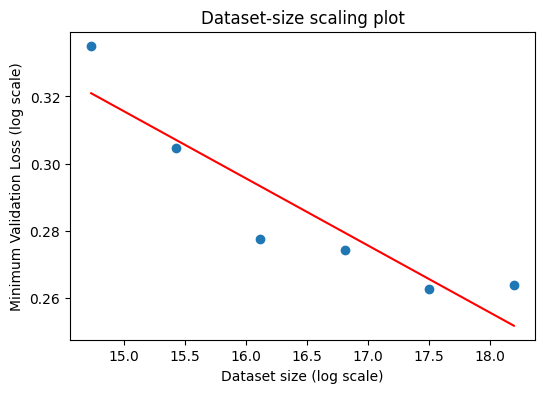

In [ ]:
# Plot the relationship between min val loss and dataset size in a log-log scale
X = np.log(dataset_sizes)
Y = np.log(minimum_losses)

plt.figure(figsize=(6, 4))
plt.scatter(X, Y)
m, b = np.polyfit(X, Y, 1)
best_fit = m*X + b
plt.plot(X, best_fit, color='red', linestyle='-')
plt.xlabel("Dataset size (log scale)")
plt.ylabel("Minimum Validation Loss (log scale)")
plt.title("Dataset-size scaling plot")
plt.show()

In [ ]:
# Print the scaling exponent
print(m)

-0.01995868613687692


### **Evaluation**

The model performs best when fed a dataset size between 20_000_000 and 80_000_000 tokens, or more specifically, a size close to 40_000_000.

Furthermore, a **very small scaling exponent** suggests that there are diminishing returns from doubling the size. Results also clearly show above that doubling the size from 40_000_000 to 80_000_000 caused a slight drop in model performance.

A solution is to scale model size upwards, to check if this adjustment of model architecture towards a deeper network improves model performance; increased capacity to capture more information when given a larger dataset may improve performance.

## **Scaling model size**

Consider the section below to explore upwards scaling of model size by increase the number of model parameters through hidden size and number of layers. Here, the experiment is to grow the model size in two ways:
- Fix number of layers, increase hidden size
- Fix hidden size, increase number of layers

**Objective**: To estimate the model size that optimizes model performance by projection of the hidden size and number of layers that achieve this, with a fixed number of 8 attention heads.


### **Scale hidden size**

This segment will focus on scaling hidden size upwards and to analyze the general trend in model performance while doing so. Number of iterations is reduced further due to longer training times associated with deeper models.

In [ ]:
# A small-scale experiment testing with these hidden sizes
hidden_sizes = [256, 512, 768]

In [ ]:
# Keep track of all results
val_loss_all = []
val_time_all = []

for h in hidden_sizes:
    # Initialize the model architecture and params
    model, params = create_train_state(key, vocab_size, h, n_layers,
                                       n_heads, max_len, activation, mlp_ratio, dropout
                                       )
    print(f"Model initialized with hidden size {h}")

    # Warmup
    warmup = optax.linear_schedule(
        init_value = 0.0,
        end_value = lr,
        transition_steps = 1_000
    )

    # cosine decay after warmup
    cos_decay = optax.cosine_decay_schedule(
        init_value = lr,
        decay_steps=20_000,
        alpha = 0.0
    )

    schedule = optax.join_schedules(
        schedules=[warmup, cos_decay],
        boundaries=[1_000]
    )

    tx = optax.chain(
        optax.clip_by_global_norm(0.5),
        optax.lion(learning_rate = schedule)
    )

    # Initialize optimizer state for current params
    opt_state = tx.init(params)
    niter = 10_000           # reduced number of iterations
    B_seq, B_tok = 64, 32

    time_val_history = []
    loss_val_history = []
    time_start = time.time()

    for it in range(niter):
        batch = get_batch(training_text_int, B_seq, B_tok)
        input, target = batch[0], batch[1]
        params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, tx)

        # update model weights and optimizer state
        params = params_new
        opt_state = opt_state_new

        # Evaluate on validation data periodically
        if it % (niter // 50) == 0 or it == niter - 1:
            time_since_start = time.time() - time_start
            # compute loss on validation set
            B_val, T_val = 1024, 32
            val_batch = get_batch(val_text_int, B_val, T_val)
            val_input, val_target = val_batch[0], val_batch[1]
            val_logits = model.apply({"params": params}, val_input)
            val_loss, val_metrics = loss_and_metrics(val_logits, val_target)
            loss_val_history.append(val_loss)
            time_val_history.append(time_since_start)

    val_loss_all.append(loss_val_history)
    val_time_all.append(time_val_history)

Model initialized with hidden size 256
Model initialized with hidden size 512
Model initialized with hidden size 768


In [ ]:
for i in range(0, len(hidden_sizes)):
    string = f"""
    For a hidden size of {hidden_sizes[i]}:
    Final validation loss: {val_loss_all[i][-1]}
    Total Training Time: {val_time_all[i][-1]}
    Minimum validation loss: {min(val_loss_all[i])} attained at {val_time_all[i][val_loss_all[i].index(min(val_loss_all[i]))]} seconds
    """
    print(string)


    For a hidden size of 256:
    Final validation loss: 1.3636267185211182
    Total Training Time: 180.9421031475067
    Minimum validation loss: 1.3636267185211182 attained at 180.9421031475067 seconds
    

    For a hidden size of 512:
    Final validation loss: 1.3399561643600464
    Total Training Time: 541.2007052898407
    Minimum validation loss: 1.3399561643600464 attained at 541.2007052898407 seconds
    

    For a hidden size of 768:
    Final validation loss: 1.4010612964630127
    Total Training Time: 1125.528647661209
    Minimum validation loss: 1.3864290714263916 attained at 993.7055068016052 seconds
    


### **Evaluation**

It is interesting to note that despite an increase in hidden size from 512 to 768, model performance actually dropped. It could be that the dataset size is too small and the model overfitted the noise in the dataset; capturing too much information.

Model performance peaks at a hidden size of 512. This will be the fixed hidden size moving forward to the next section, where the number of layers is scaled upwards.

### **Scale layers**

This segment fixes the hidden size at 512 and tests if growing the number of layers, above the original number of 4, improves model performance.

The results will be compared with the control set up (hidden size = 512, number of layers = 4, number of heads = 8), of which its results are above.

In [ ]:
hidden_size = 512
number_layers = [8, 16]

# Set number of attention heads at 8
print(n_heads)

8


In [ ]:
# Keep track of all results
val_loss_all = []
val_time_all = []

for n in number_layers:
    # Initialize the model architecture and params
    model, params = create_train_state(key, vocab_size, hidden_size, n,
                                       n_heads, max_len, activation, mlp_ratio, dropout
                                       )
    print(f"Model initialized with {n} layers with hidden size of 512, 8 attention heads")


    # Warmup
    warmup = optax.linear_schedule(
        init_value = 0.0,
        end_value = lr,
        transition_steps = 1_000
    )

    # cosine decay after warmup
    cos_decay = optax.cosine_decay_schedule(
        init_value = lr,
        decay_steps=20_000,
        alpha = 0.0
    )

    schedule = optax.join_schedules(
        schedules=[warmup, cos_decay],
        boundaries=[1_000]
    )

    tx = optax.chain(
        optax.clip_by_global_norm(0.5),
        optax.lion(learning_rate = schedule)
    )

    # Initialize optimizer state for current params
    opt_state = tx.init(params)
    niter = 10_000           # Similarly, reduce the number of iterations for small-scale experiments
    B_seq, B_tok = 64, 32

    time_val_history = []
    loss_val_history = []
    time_start = time.time()

    for it in range(niter):
        batch = get_batch(training_text_int, B_seq, B_tok)
        input, target = batch[0], batch[1]
        params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, tx)

        # update model weights and optimizer state
        params = params_new
        opt_state = opt_state_new

        # Evaluate on validation data periodically
        if it % (niter // 50) == 0 or it == niter - 1:
            time_since_start = time.time() - time_start
            # compute loss on validation set
            B_val, T_val = 1024, 32
            val_batch = get_batch(val_text_int, B_val, T_val)
            val_input, val_target = val_batch[0], val_batch[1]
            val_logits = model.apply({"params": params}, val_input)
            val_loss, val_metrics = loss_and_metrics(val_logits, val_target)
            loss_val_history.append(val_loss)
            time_val_history.append(time_since_start)

    val_loss_all.append(loss_val_history)
    val_time_all.append(time_val_history)

Model initialized with 8 layers with hidden size of 512, 8 attention heads
Model initialized with 16 layers with hidden size of 512, 8 attention heads


In [ ]:
for i in range(0, len(number_layers)):
    string = f"""
    For {number_layers[i]} layers:
    Final validation loss: {val_loss_all[i][-1]}
    Total Training Time: {val_time_all[i][-1]}
    Minimum validation loss: {min(val_loss_all[i])} attained at {val_time_all[i][val_loss_all[i].index(min(val_loss_all[i]))]} seconds
    """
    print(string)


    For 8 layers:
    Final validation loss: 1.3578410148620605
    Total Training Time: 1179.2640459537506
    Minimum validation loss: 1.3260011672973633 attained at 1156.0918817520142 seconds
    

    For 16 layers:
    Final validation loss: 1.354722023010254
    Total Training Time: 2333.121618270874
    Minimum validation loss: 1.3276827335357666 attained at 2148.9043684005737 seconds
    


### **Evaluation**

For reference, the control setup with 4 layers give a minimum validation loss of 1.34 in 541.2 seconds.

Given the results shown above, it is preferred to choose 8 layers as compared to 16 layers. However, in the interest of time, it is difficult to decide between 4 and 8 layers because the training time doubled for a slight improvement in model performance; minimal validation loss decreased by ~0.02 from 1.340 to 1.326.

**Decision**: Going forward, doubling the number of layers from 4 to 8 may be considered for the final model, if it has a hidden size of 512.


## **Exploring loss designs**

Currently the loss function calculates the average cross-entropy loss over all positions.

This experiment is to change the loss function's design to compute the loss only on the last token of each sequence.

**Evaluation metrics**:
- Performance: Accuracy at last token
- **Training Time**: To check if any change in design sacrifices longer training time for a shift in model learning

In [8]:
# Warmup
warmup = optax.linear_schedule(
    init_value = 0.0,
    end_value = lr,
    transition_steps = 1_000
    )

# cosine decay after warmup
cos_decay = optax.cosine_decay_schedule(
    init_value = lr,
    decay_steps=20_000,
    alpha = 0.0
    )

schedule = optax.join_schedules(
    schedules=[warmup, cos_decay],
    boundaries=[1_000]
    )

tx = optax.chain(
    optax.clip_by_global_norm(0.5),
    optax.lion(learning_rate = schedule)
    )

### **Control setup**

Loss applied to every position

In [10]:
# Initialize the model architecture and params
model, params = create_train_state(key, vocab_size, d_model, n_layers,
                                       n_heads, max_len, activation, mlp_ratio, dropout
                                       )

# Initialize optimizer state for current params
opt_state = tx.init(params)
niter = 20_000
B_seq, B_tok = 64, 32

time_val_history = []
acc_last_history = []
acc_history = []
time_start = time.time()

for it in range(niter):
    batch = get_batch(training_text_int, B_seq, B_tok)
    input, target = batch[0], batch[1]
    params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, tx)

    # update model weights and optimizer state
    params = params_new
    opt_state = opt_state_new

    # Evaluate on validation data periodically
    if it % (niter // 50) == 0 or it == niter - 1:
        time_since_start = time.time() - time_start
        # compute loss on validation set
        B_val, T_val = 1024, 32
        val_batch = get_batch(val_text_int, B_val, T_val)
        val_input, val_target = val_batch[0], val_batch[1]
        val_logits = model.apply({"params": params}, val_input)
        val_loss, val_metrics = loss_and_metrics(val_logits, val_target)
        # Only get the accuracy of the last token because that is the main output(next char prediction)
        val_acc, val_acc_last = val_metrics['acc'], val_metrics['acc_last']
        time_val_history.append(time_since_start)
        acc_history.append(val_acc)
        acc_last_history.append(val_acc_last)

### **Modified setup**

Loss applied at last position

In [23]:
# Modified loss function
@jax.jit
def loss_and_metrics_mod(logits, targets):
    """
    Assumes `targets` contains only valid integer class ids in [0, V-1]

    Args: Model's predictions and correct tokens
      logits: (B_seq, B_tok, vocab_size)
      targets: (B_seq, B_tok) ground-truth class ids.

    Returns:
      loss: a scalar. Cross-entropy loss on LAST token for each sequence, averaged over all batches.
      metrics: a dict.
    """
    # Instead of flattening all logits and targets, extract last token from each sequence for both.
    last_logits = logits[:, -1, :]
    last_targets = targets[:, -1]

    # Mean of "last token loss", over all batches
    loss = optax.softmax_cross_entropy_with_integer_labels(
        last_logits, last_targets).mean()


    # Accuracy over all tokens
    preds_all = jnp.argmax(logits, axis = -1)
    is_match_all = preds_all == targets
    acc_all = jnp.mean(is_match_all.astype(jnp.float32))

    # Accuracy over only last token of each sequence
    preds = jnp.argmax(last_logits, axis=-1)
    is_match = preds == last_targets
    acc_last = jnp.mean(is_match.astype(jnp.float32))

    return loss, {"loss": loss, "acc": acc_all, "acc_last": acc_last}

In [24]:
# a single gradient update
def train_step_mod(params, opt_state, x, y, tx):
    """
    Args:
      params: pytree of model parameters.
      opt_state: optax optimizer state corresponding to `params`.
      x: (B_seq, B_tok) int array input tokens.
      y: (B_seq, B_tok) int array target tokens.
      tx: optax.GradientTransformation (already initialized).

    Returns:
      new_params: updated parameters after one gradient step.
      new_opt_state: updated optimizer state.
      metrics: dict of scalar metrics (loss, acc).
    """
    def loss_fn(params):
        logits = model.apply({"params": params}, x)
        loss, metrics = loss_and_metrics_mod(logits, y)
        return loss, metrics

    # compute gradients of loss w.r.t params (loss is scalar, metrics is auxiliary)
    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # optax update: update params and new optimizer state
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, metrics

# jit: last argument should be static because it is an object
train_step_mod = jax.jit(train_step_mod, static_argnames=("tx",))

In [25]:
# Initialize the model architecture and params
model, params = create_train_state(key, vocab_size, d_model, n_layers,
                                       n_heads, max_len, activation, mlp_ratio, dropout
                                       )

# Initialize optimizer state for current params
opt_state = tx.init(params)
niter = 20_000
B_seq, B_tok = 64, 32

time_val_history_mod = []
acc_last_history_mod = []
acc_history_mod = []
time_start = time.time()

for it in range(niter):
    batch = get_batch(training_text_int, B_seq, B_tok)
    input, target = batch[0], batch[1]
    params_new, opt_state_new, metrics = train_step_mod(params, opt_state, input, target, tx)

    # update model weights and optimizer state
    params = params_new
    opt_state = opt_state_new

    # Evaluate on validation data periodically
    if it % (niter // 50) == 0 or it == niter - 1:
        time_since_start = time.time() - time_start
        # compute loss on validation set
        B_val, T_val = 1024, 32
        val_batch = get_batch(val_text_int, B_val, T_val)
        val_input, val_target = val_batch[0], val_batch[1]
        val_logits = model.apply({"params": params}, val_input)
        val_loss, val_metrics = loss_and_metrics_mod(val_logits, val_target)
        # Only get the accuracy of the last token because that is the main output(next char prediction)
        val_acc, val_acc_last = val_metrics['acc'], val_metrics['acc_last']
        acc_last_history_mod.append(val_acc_last)
        acc_history_mod.append(val_acc)
        time_val_history_mod.append(time_since_start)

### **Evaluation**

The plots below show the accuracies (on the validation set) of the last position and all positions respectively. It is clear that applying last-token loss produces a worse result in terms of performance and convergence.

Therefore, the decision is to stick to applying the loss at every position.

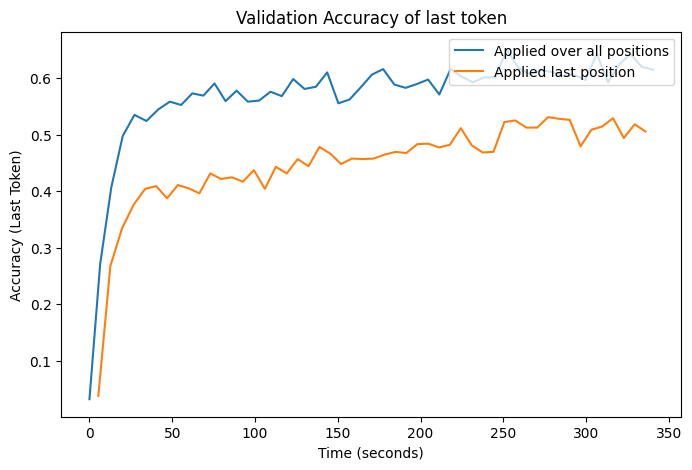

In [26]:
plt.figure(figsize=(8,5))

plt.plot(time_val_history, acc_last_history, label = f"Applied over all positions")
plt.plot(time_val_history_mod, acc_last_history_mod, label = f"Applied last position")

plt.xlabel("Time (seconds)")
plt.ylabel("Accuracy (Last Token)")
plt.title("Validation Accuracy of last token")
plt.legend(loc='upper right')

plt.show()

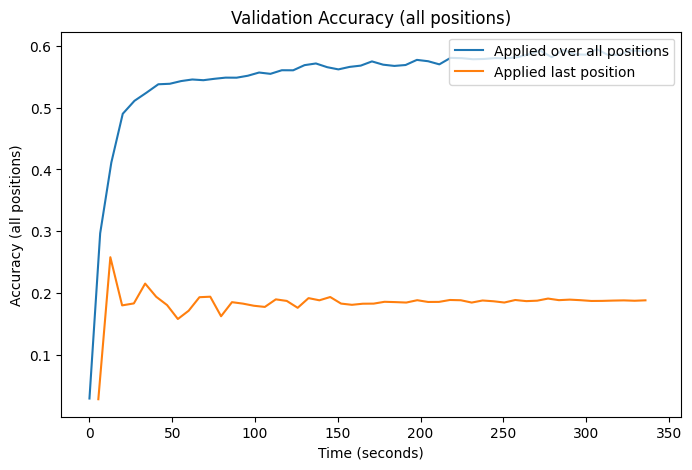

In [27]:
plt.figure(figsize=(8,5))

plt.plot(time_val_history, acc_history, label = f"Applied over all positions")
plt.plot(time_val_history_mod, acc_history_mod, label = f"Applied last position")

plt.xlabel("Time (seconds)")
plt.ylabel("Accuracy (all positions)")
plt.title("Validation Accuracy (all positions)")
plt.legend(loc='upper right')

plt.show()